# Daisy Model
Data of a laboratory setup acting like a hair dryer 

### Description
Laboratory setup acting like a hair dryer. Air is fanned through a tube and heated at the inlet. The air temperature is measured by a thermocouple at the output. The input is the voltage over the heating device (a mesh of resistor wires).

### Sampling
**Number:** 1000

### Inputs
- **u:** voltage of the heating device

### Outputs
- **y:** output air temperature

### References
- Ljung L. *System Identification - Theory for the User.* Prentice Hall, Englewood Cliffs, NJ, 1987.  
- Ljung L. *System Identification Toolbox. For Use with Matlab.* The Mathworks Inc., Mass., U.S.A., 1991.

### Properties
**Columns:**
- Column 1: input u  
- Column 2: output y

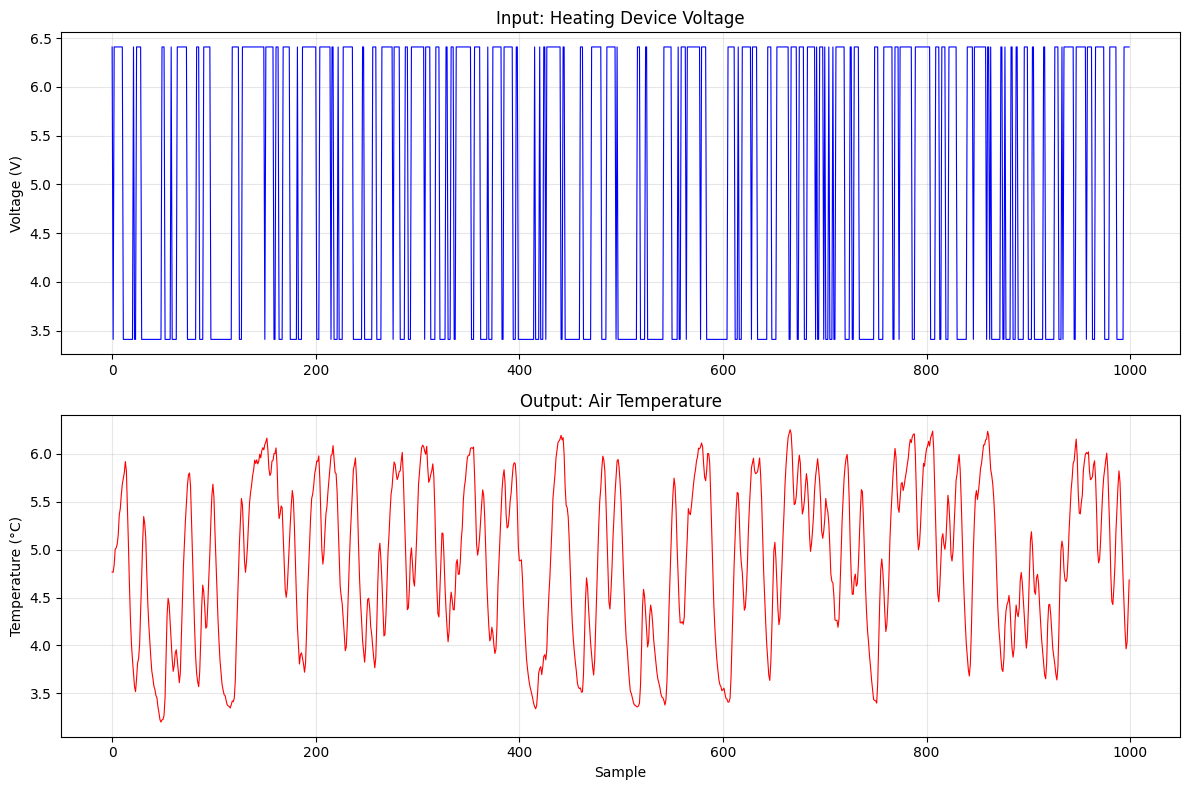

Number of samples: 1000
Voltage range: [3.41, 6.41] V
Temperature range: [3.20, 6.25] °C


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos
data = np.loadtxt('dryer.dat')
u = data[:, 0]  # voltage input
y = data[:, 1]  # output temperature

# Crear figura con subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfica de la entrada (voltaje)
ax1.plot(u, 'b-', linewidth=0.8)
ax1.set_ylabel('Voltage (V)', fontsize=10)
ax1.set_title('Input: Heating Device Voltage', fontsize=12)
ax1.grid(True, alpha=0.3)

# Gráfica de la salida (temperatura)
ax2.plot(y, 'r-', linewidth=0.8)
ax2.set_xlabel('Sample', fontsize=10)
ax2.set_ylabel('Temperature (°C)', fontsize=10)
ax2.set_title('Output: Air Temperature', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Información básica de los datos
print(f"Number of samples: {len(u)}")
print(f"Voltage range: [{u.min():.2f}, {u.max():.2f}] V")
print(f"Temperature range: [{y.min():.2f}, {y.max():.2f}] °C")


MODELO ARX ESTIMADO
Orden: na=2, nb=2, nk=1

Polinomio A(q^-1):
  1 + (-1.688955)q^-1 + (0.738483)q^-2

Polinomio B(q^-1):
  (0.003801)q^-1 + (0.044176)q^-2

MÉTRICAS DE AJUSTE
MSE:  0.044297
RMSE: 0.210468
FIT:  74.65%


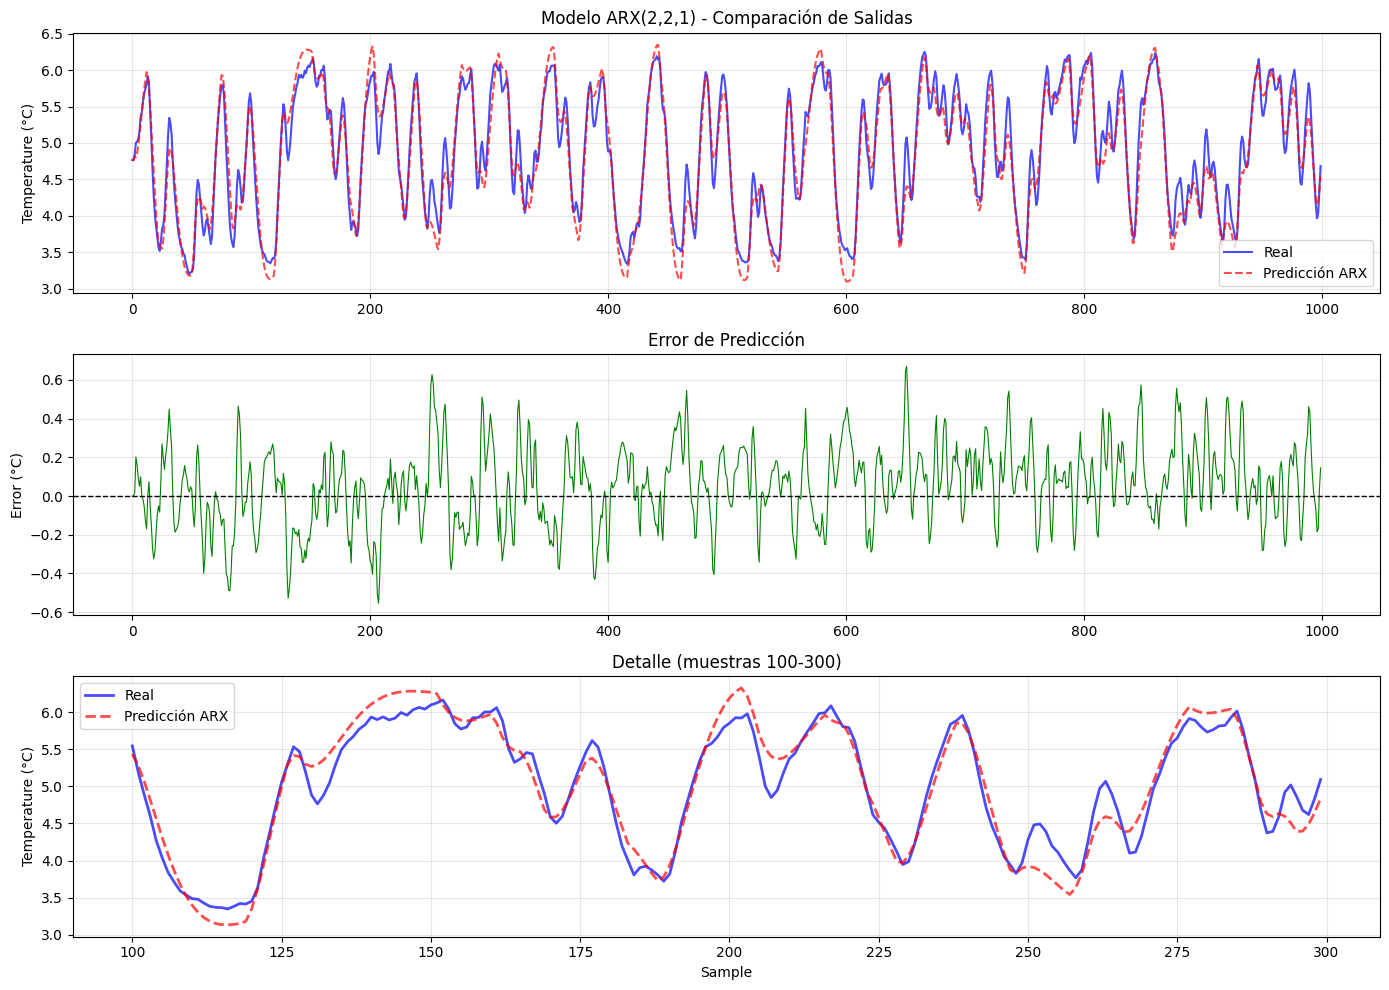

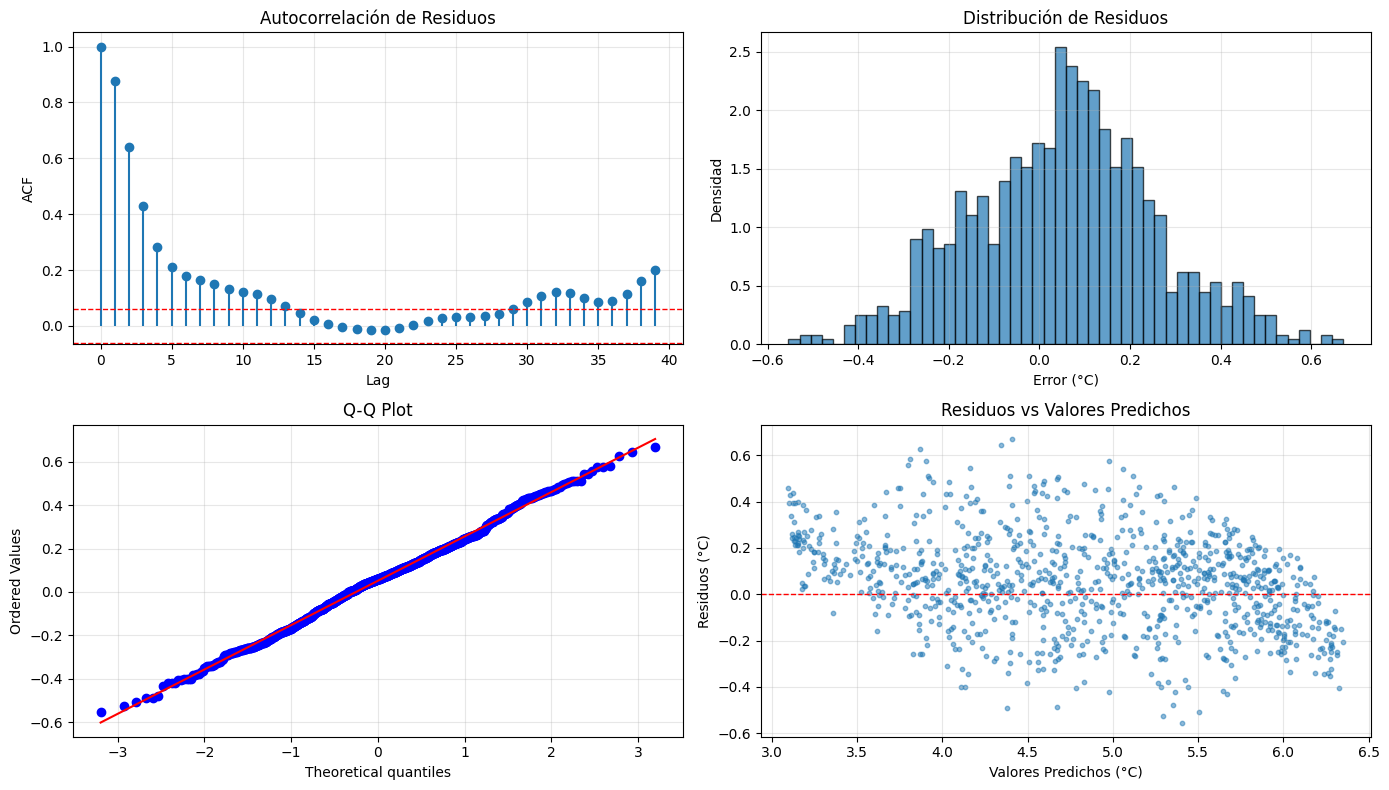

In [ ]:
from scipy import linalg


# Parámetros del modelo ARX
# Modelo ARX: A(q)y(t) = B(q)u(t) + e(t)
# y(t) = -a1*y(t-1) - a2*y(t-2) - ... - ana*y(t-na) + b1*u(t-nk) + b2*u(t-nk-1) + ... + bnb*u(t-nk-nb+1) + e(t)

na = 2  # Orden del polinomio A (autorregresivo)
nb = 2  # Orden del polinomio B (entrada)
nk = 1  # Retardo (delay) del sistema

# Construcción de la matriz de regresores
N = len(u)
max_lag = max(na, nb + nk - 1)

# Inicializar matriz de regresores y vector de salida
phi = []
y_vec = []

for t in range(max_lag, N):
    # Regresores de salida pasada: -y(t-1), -y(t-2), ..., -y(t-na)
    y_regs = [-y[t-i] for i in range(1, na+1)]
    
    # Regresores de entrada pasada: u(t-nk), u(t-nk-1), ..., u(t-nk-nb+1)
    u_regs = [u[t-nk-i] for i in range(nb)]
    
    # Concatenar regresores
    phi.append(y_regs + u_regs)
    y_vec.append(y[t])

# Convertir a arrays de numpy
phi = np.array(phi)
y_vec = np.array(y_vec)

# Estimación por mínimos cuadrados: theta = (phi^T * phi)^-1 * phi^T * y
theta = linalg.lstsq(phi, y_vec)[0]

# Extraer parámetros
a_params = theta[:na]
b_params = theta[na:]

print("=" * 60)
print("MODELO ARX ESTIMADO")
print("=" * 60)
print(f"Orden: na={na}, nb={nb}, nk={nk}")
print(f"\nPolinomio A(q^-1):")
print(f"  1", end="")
for i, a in enumerate(a_params, 1):
    print(f" + ({a:.6f})q^-{i}", end="")
print()

print(f"\nPolinomio B(q^-1):")
for i, b in enumerate(b_params, nk):
    if i == nk:
        print(f"  ({b:.6f})q^-{i}", end="")
    else:
        print(f" + ({b:.6f})q^-{i}", end="")
print()

# Simulación del modelo
y_pred = np.zeros(N)
y_pred[:max_lag] = y[:max_lag]  # Condiciones iniciales

for t in range(max_lag, N):
    # Predicción un paso adelante
    y_ar = sum(-a_params[i] * y_pred[t-i-1] for i in range(na))
    y_b = sum(b_params[i] * u[t-nk-i] for i in range(nb))
    y_pred[t] = y_ar + y_b

# Error de predicción
error = y - y_pred
mse = np.mean(error[max_lag:]**2)
rmse = np.sqrt(mse)
fit = 100 * (1 - np.linalg.norm(y[max_lag:] - y_pred[max_lag:]) / np.linalg.norm(y[max_lag:] - np.mean(y[max_lag:])))

print(f"\n{'=' * 60}")
print("MÉTRICAS DE AJUSTE")
print("=" * 60)
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"FIT:  {fit:.2f}%")
print("=" * 60)

# Gráficas de comparación
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Gráfica 1: Salida real vs predicha
axes[0].plot(y, 'b-', label='Real', linewidth=1.5, alpha=0.7)
axes[0].plot(y_pred, 'r--', label='Predicción ARX', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('Temperature (°C)', fontsize=10)
axes[0].set_title(f'Modelo ARX({na},{nb},{nk}) - Comparación de Salidas', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfica 2: Error de predicción
axes[1].plot(error, 'g-', linewidth=0.8)
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=1)
axes[1].set_ylabel('Error (°C)', fontsize=10)
axes[1].set_title('Error de Predicción', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Gráfica 3: Zoom en una región
zoom_start, zoom_end = 100, 300
axes[2].plot(range(zoom_start, zoom_end), y[zoom_start:zoom_end], 'b-', 
             label='Real', linewidth=2, alpha=0.7)
axes[2].plot(range(zoom_start, zoom_end), y_pred[zoom_start:zoom_end], 'r--', 
             label='Predicción ARX', linewidth=2, alpha=0.7)
axes[2].set_xlabel('Sample', fontsize=10)
axes[2].set_ylabel('Temperature (°C)', fontsize=10)
axes[2].set_title(f'Detalle (muestras {zoom_start}-{zoom_end})', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de residuos
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Autocorrelación de residuos
max_lag_acf = 40
acf = np.correlate(error[max_lag:], error[max_lag:], mode='full')
acf = acf[len(acf)//2:len(acf)//2 + max_lag_acf]
acf = acf / acf[0]

axes[0, 0].stem(range(max_lag_acf), acf, basefmt=' ')
axes[0, 0].axhline(y=1.96/np.sqrt(N-max_lag), color='r', linestyle='--', linewidth=1)
axes[0, 0].axhline(y=-1.96/np.sqrt(N-max_lag), color='r', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('Lag', fontsize=10)
axes[0, 0].set_ylabel('ACF', fontsize=10)
axes[0, 0].set_title('Autocorrelación de Residuos', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Histograma de residuos
axes[0, 1].hist(error[max_lag:], bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Error (°C)', fontsize=10)
axes[0, 1].set_ylabel('Densidad', fontsize=10)
axes[0, 1].set_title('Distribución de Residuos', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(error[max_lag:], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Residuos vs predicción
axes[1, 1].scatter(y_pred[max_lag:], error[max_lag:], alpha=0.5, s=10)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Valores Predichos (°C)', fontsize=10)
axes[1, 1].set_ylabel('Residuos (°C)', fontsize=10)
axes[1, 1].set_title('Residuos vs Valores Predichos', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()